In [1]:
%tensorflow_version 2.x
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time

print(sys.version_info)
for module in mpl, np, pd, sklearn:
    print(module.__name__, module.__version__)

TensorFlow 2.x selected.
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.4
pandas 0.25.3
sklearn 0.21.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 1. 加载数据
# 2. 数据预处理 -> dataset
# 3. 工具函数
# 3.1 生成位置编码
# 3.2 生成mask (a. padding, b. decoder)
# 3.3 scaled_dot_product_attention（缩放点击注意力）
# 4. 构建模型
# 4.1 MultiheadAttention
# 4.2 EncoderLayer
# 4.3 DecoderLayer
# 4.4 EncoderModel
# 4.5 DecoderModel
# 4.6 Transformer
# 5. optimizer & loss函数
# 6. 训练：train step -> train
# 7. 预测

In [4]:
import tensorflow as tf

print(tf.__version__)
tf.keras.backend.clear_session()
from tensorflow import keras

2.0.0


In [5]:
import tensorflow_datasets as tfds

# 加载数据
examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                           with_info = True,
                           as_supervised = True)

# 划分训练集和测试集
train_examples, val_examples = examples['train'], examples['validation']
print(info)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/0.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=0.0.1,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    urls=['https://github.com/neulab/word-embeddings-for-nmt'],
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation

In [6]:
# 查看数据
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'
b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them ."

b'o problema \xc3\xa9 que nunca vivi l\xc3\xa1 um \xc3\xbanico dia .'
b"except , i 've never lived one day of my life there ."

b'agora aqui temos imagens sendo extra\xc3\xaddas em tempo real diretamente do feed ,'
b'now here are live images being pulled straight from the feed .'

b'agora : um , dois , tr\xc3\xaas , vai .'
b'so : one , two , three , go .'

b'eventualmente , vamos ver se teremos todos os sentidos humanos empregues , e se vamos ter meios para viver a hist\xc3\xb3ria qualquer que seja a via escolhida .'
b'eventually , we can see i

In [0]:
# 从训练数据集创建自定义子词分词器（subwords tokenizer）
# 2^13 = 8192
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)


In [8]:
sample_string = "Transformer is awesome."

# 如果单词不在词典中，则分词器（tokenizer）通过将单词分解为子词来对字符串进行编码。
tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"'.format(token, en_tokenizer.decode([token])))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915 --> "T"
1248 --> "ran"
7946 --> "s"
7194 --> "former "
13 --> "is "
2799 --> "awesome"
7877 --> "."


In [0]:
buffer_size = 20000
batch_size = 64
max_length = 40

# 将开始和结束标记（token）添加到输入和目标
def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence

# 删除长度大于40个标记的样本
def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)

def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [pt_sentence, en_sentence],
                          [tf.int64, tf.int64])
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))
    

In [10]:
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 40) (64, 40)
(64, 38) (64, 40)
(64, 40) (64, 40)
(64, 39) (64, 39)
(64, 37) (64, 38)


In [11]:
# 生成位置编码
# 因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。
# PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

# pos.shape: [sentence_length, 1]
# i.shape  : [1, d_model]
# result.shape: [sentence_length, d_model]
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000,
                               (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def get_position_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # sines.shape: [sentence_length, d_model / 2]
    # cosines.shape: [sentence_length, d_model / 2]
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]
    
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(50, 512)
print(position_embedding.shape)

(1, 50, 512)


In [12]:
# 1. padding mask(遮挡一批序列中所有的填充标记，以免影响模型训练效果)
# 2. look ahead(掩盖序列中后面的单词，预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推)

# batch_data.shape: [batch_size, seq_len]
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=208871, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [13]:
# attention_weights.shape: [3,3]
# [[1, 0, 0],
#  [4, 5, 0],
#  [7, 8, 9]]
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

create_look_ahead_mask(3)

<tf.Tensor: id=208879, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [0]:
# 缩放点击注意力
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    depth = d_model / num_head
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        # 使得在softmax后值趋近于0
        scaled_attention_logits += (mask * -1e9)
    
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    # softmax 在最后一个轴（seq_len_k）上归一化
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis = -1)
    
    # 当 softmax 在 K 上进行归一化后，它的值决定了分配到 Q 的重要程度。
    # 输出表示注意力权重和 V（数值）向量的乘积。这确保了要关注的词保持原样，而无关的词将被清除掉。
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)
    

In [15]:
# 多头注意力
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上:
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    
    实战中:
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    
    实战中技巧：
    q -> Wq -> Q -> split -> q0, q1, q2...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, depth)
        
        x = tf.reshape(x,
                       (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.WQ(q) # q.shape: (batch_size, seq_len_q, d_model)
        k = self.WK(k) # k.shape: (batch_size, seq_len_k, d_model)
        v = self.WV(v) # v.shape: (batch_size, seq_len_v, d_model)
        
        # q.shape: (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)
        
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm = [0, 2, 1, 3])
        # concat_attention.shape: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs,
                                      (batch_size, -1, self.d_model))
        
        # output.shape : (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights
    
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 256)) # (batch_size, seq_len_q, dim)
output, attn = temp_mha(y, y, y, mask = None)
print(output.shape)
print(attn.shape)

(1, 60, 512)
(1, 8, 60, 60)


In [16]:
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [17]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feed_forward -> add & normalize & dropout
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape          : (batch_size, seq_len, dim=d_model)
        # attn_output.shape: (batch_size, seq_len, d_model)
        # out1.shape       : (batch_size, seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, encoder_padding_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(x + attn_output)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        # out2.shape      : (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)
        
        return out2

sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)


In [18]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1 , encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> ffn -> add & normalize & dropout -> out3
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask: 由look_ahead_mask和decoder_padding_mask合并而来
        
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        
        # attn1, out1.shape : (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(attn1 + x)
        
        # attn2, out2.shape : (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs,
            encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layer_norm2(attn2 + out1)
        
        # ffn_output, out3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2
    
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)

print(sample_decoder_output.shape)
print(sample_decoder_attn_weights1.shape)
print(sample_decoder_attn_weights2.shape)
        

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


In [19]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        
        self.embedding = keras.layers.Embedding(input_vocab_size,
                                                self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         self.d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training,
                                       encoder_padding_mask)
        
        # x.shape: (batch_size, input_seq_len, d_model)
        return x
    
sample_encoder_model = EncoderModel(2, 8500, max_length,
                                    512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, False, encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


In [20]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size,
                                                d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")
        
        attention_weights = {}
        
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x, attn1, attn2 = self.decoder_layers[i](
                x, encoding_outputs, training,
                decoder_mask, encoder_decoder_padding_mask)
            attention_weights[
                'decoder_layer{}_att1'.format(i+1)] = attn1
            attention_weights[
                'decoder_layer{}_att2'.format(i+1)] = attn2
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights

sample_decoder_model = DecoderModel(2, 8000, max_length,
                                    512, 8, 2048)

sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att \
= sample_decoder_model(
    sample_decoder_model_input,
    sample_encoder_model_output,
    training = False, decoder_mask = None,
    encoder_decoder_padding_mask = None)

print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [21]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(
            num_layers, input_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.decoder_model = DecoderModel(
            num_layers, target_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.final_layer = keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(
            inp, training, encoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training,
            decoder_mask, encoder_decoder_padding_mask)
        
        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights
    
sample_transformer = Transformer(2, 8500, 8000, max_length,
                                 512, 8, 2048, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sample_transformer(
    temp_input, temp_target, training = False,
    encoder_padding_mask = None,
    decoder_mask = None,
    encoder_decoder_padding_mask = None)

print(predictions.shape)
for key in attention_weights:
    print(key, attention_weights[key].shape)
        

(64, 31, 8000)
decoder_layer1_att1 (64, 8, 31, 31)
decoder_layer1_att2 (64, 8, 31, 26)
decoder_layer2_att1 (64, 8, 31, 31)
decoder_layer2_att2 (64, 8, 31, 26)


In [0]:
# 1. 初始化模型.
# 2. 定义 loss_function, optimizer, learning_rate schedule
# 3. train_step
# 4. 进行训练

In [23]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

print(input_vocab_size, target_vocab_size)

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)

8216 8089


In [0]:
# 自定义学习率
# lrate = (d_model ** -0.5) * min(step_num ** (-0.5),
#                                 step_num * warm_up_steps **(-1.5))

class CustomizedSchedule(
    keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,
                                  beta_1 = 0.9,
                                  beta_2 = 0.98,
                                  epsilon = 1e-9)

Text(0.5, 0, 'Train step')

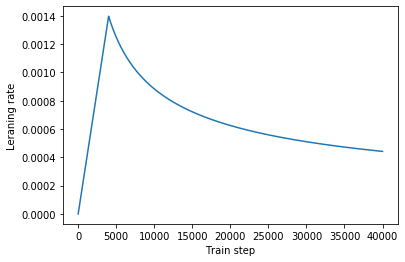

In [25]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)

plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")

In [0]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [27]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/transformer"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果checkpoint存在, 恢复最新的一个checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [0]:
def create_masks(inp, tar):
    """
    Encoder:
      - encoder_padding_mask (self attention of EncoderLayer)
    Decoder:
      - look_ahead_mask (self attention of DecoderLayer)
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
      - decoder_padding_mask (self attention of DecoderLayer)
    """
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    decoder_mask = tf.maximum(decoder_padding_mask,
                              look_ahead_mask)
    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [0]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

In [30]:
print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)

(64, 39)
(64, 40)


(<tf.Tensor: id=306114, shape=(64, 1, 1, 39), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: id=306146, shape=(64, 1, 40, 40), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1

In [0]:
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(
    name = 'train_accuracy')

@tf.function
def train_step(inp, tar):
    # 输入到模型
    tar_inp  = tar[:, :-1]
    # 与模型输出对比，求出损失函数
    tar_real = tar[:, 1:]
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        # tar_real.shape: (batch_size, output_seq_len)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

epochs = 30
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))
    ckpt_save_path = ckpt_manager.save()
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(
        time.time() - start))
    

Epoch 1 Batch 0 Loss 0.2247 Accuracy 0.4317


Epoch 1 Batch 100 Loss 0.2360 Accuracy 0.4074
Epoch 1 Batch 200 Loss 0.2418 Accuracy 0.4053
Epoch 1 Batch 300 Loss 0.2462 Accuracy 0.4042
Epoch 1 Batch 400 Loss 0.2494 Accuracy 0.4036
Epoch 1 Batch 500 Loss 0.2526 Accuracy 0.4021
Epoch 1 Batch 600 Loss 0.2570 Accuracy 0.4016
Epoch 1 Batch 700 Loss 0.2609 Accuracy 0.4007
Epoch 1 Loss 0.2610 Accuracy 0.4007
Time take for 1 epoch: 402.06263041496277 secs

Epoch 2 Batch 0 Loss 0.2384 Accuracy 0.4123
Epoch 2 Batch 100 Loss 0.2329 Accuracy 0.4066
Epoch 2 Batch 200 Loss 0.2396 Accuracy 0.4042
Epoch 2 Batch 300 Loss 0.2432 Accuracy 0.4051
Epoch 2 Batch 400 Loss 0.2473 Accuracy 0.4043
Epoch 2 Batch 500 Loss 0.2505 Accuracy 0.4042
Epoch 2 Batch 600 Loss 0.2536 Accuracy 0.4030
Epoch 2 Batch 700 Loss 0.2574 Accuracy 0.4015
Epoch 2 Loss 0.2575 Accuracy 0.4015
Time take for 1 epoch: 127.61279654502869 secs

Epoch 3 Batch 0 Loss 0.2439 Accuracy 0.4319
Epoch 3 Batch 100 Loss 0.2311 Accuracy 0.4081
Epoch 3 Batch 200 Loss 0.2373 Accuracy 0.4082
Epoch 3 

In [0]:
"""
eg: A B C D -> E F G H.
Train: A B C D, E F G -> F G H
Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
"""
def evaluate(inp_sentence):
    input_id_sentence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    # encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # decoder_input.shape: (1, 1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # predictions.shape: (batch_size, target_vocab_size)
        predictions = predictions[:, -1, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1),
                               tf.int32)
        
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        decoder_input = tf.concat([decoder_input, [predicted_id]],
                                  axis = -1)
    return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        

In [0]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    fig = plt.figure(figsize = (16, 8))
    
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        
        ax.matshow(attention[head][:-1, :])
        
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result) - 1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()      

In [0]:
def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)
    
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                       result, layer_name)

In [0]:
translate('está muito frio aqui.')

Input: está muito frio aqui.
Predicted translation: it 's very cold here , all around this world .


In [0]:
translate('isto é minha vida')

Input: isto é minha vida
Predicted translation: this is my lifelong life here in my life .


In [0]:
translate('você ainda está em casa?')

Input: você ainda está em casa?
Predicted translation: are you still home ?


In [0]:
translate('este é o primeiro livro que eu já li')

Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i ever got on before .


Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i ever had been on before .
Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i ever had been on before .


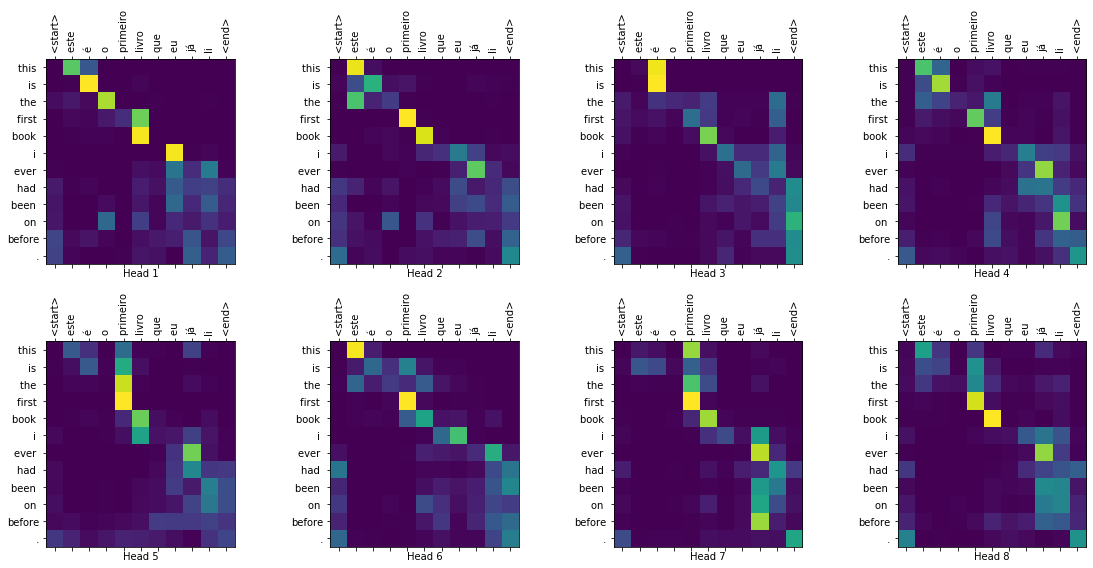

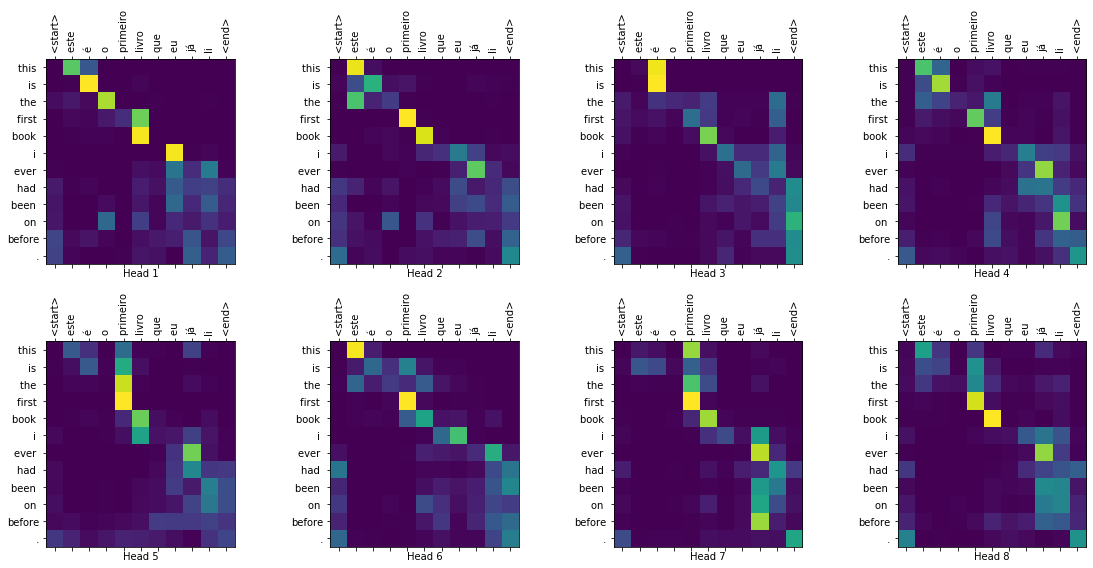

In [0]:
translate('este é o primeiro livro que eu já li',
          layer_name = 'decoder_layer4_att2')

In [0]:
translate('Te amo, nada que ver contigo.')

Input: Te amo, nada que ver contigo.
Predicted translation: to explain and explain and nothing to you .


In [0]:
# 你今天吃饭了吗
translate('Você já comeu hoje?')

Input: Você já comeu hoje?
Predicted translation: are you there a couple of people starting today ?


In [0]:
# 我喜欢python
translate('Eu gosto de python')

Input: Eu gosto de python
Predicted translation: they invited york with attention .


In [0]:
translate('ser ou não ser, eis uma questão')

Input: ser ou não ser, eis uma questão
Predicted translation: well , being out to be , here 's a question .


In [0]:
# Never put off what you can do today until tomorrow.
translate('Nunca adie o que você pode fazer hoje até amanhã.')

Input: Nunca adie o que você pode fazer hoje até amanhã.
Predicted translation: and it peaceful of it can make you even tomorrow.... ''
